In [66]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#scikit-learn
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report

import shap

In [2]:
data_brut = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/2016_Building_Energy_Nettoyage_v2.csv"
df = pd.read_csv(data_brut)

data_brut = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/2016_Building_Energy_Nettoyage_v1.csv"
df1 = pd.read_csv(data_brut)

In [3]:
# Définie les options d'affichage pour les lignes et colonnes
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',80)

In [4]:
df = df.drop(columns=["Unnamed: 0","Latitude","Longitude"])

In [5]:
df.isna().mean().sort_values(ascending=False).head(5)

Prop.Electricity                                        0.001313
Prop.NaturalGas                                         0.001313
index                                                   0.000000
Personal Services (Health/Beauty, Dry Cleaning, etc)    0.000000
Residence Hall/Dormitory                                0.000000
dtype: float64

In [6]:
df = df.dropna()

In [7]:
print("Pourcentage de valeurs nulles: {}%".format(df.isna().mean().sum()))

Pourcentage de valeurs nulles: 0.0%


In [8]:
df.select_dtypes(include="object").columns

Index([], dtype='object')

In [9]:
df.select_dtypes(include=["int","float"]).columns

Index(['index', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'SiteEnergyUseWN(kBtu)', 'Prop.Electricity',
       'Prop.NaturalGas', 'Adult Education', 'Automobile Dealership',
       'Bank Branch', 'College/University', 'Convention Center', 'Courthouse',
       'Data Center', 'Distribution Center', 'Financial Office',
       'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Service',
       'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School',
       'Laboratory', 'Library', 'Lifestyle Center',
       'Manufacturing/Industrial Plant', 'Medical Office', 'Movie Theater',
       'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office',
       'Other', 'Other - Education', 'Other - Entertainment/Public Assembly',
       'Other - Lodging/Residential', 'Other - Mall',
       'Other - Public Services', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Services', 'Other - Utility',
       'Other/Specialty Hospit

In [10]:
X = df.drop(columns="SiteEnergyUseWN(kBtu)")
y = df["SiteEnergyUseWN(kBtu)"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

#categorical_transformer = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.columns)])
#        ('cat', categorical_transformer, categorical_cols)])

# KNeighborsRegressor()

In [12]:
tt = TransformedTargetRegressor(regressor=KNeighborsRegressor(),func=np.log1p, inverse_func=np.expm1)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'model__regressor__n_neighbors': list(range(1, 30)),
}

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, verbose=1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Fitting 3 folds for each of 29 candidates, totalling 87 fits


0.482172642310168
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['index', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'Prop.Electricity', 'Prop.NaturalGas',
       'Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse', 'Dat...
       'Urgent Care/Clinic/Other Outpatient', 'Wholesale Club/Supercenter',
       'Worship Facility', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Enclosed Mall', 'Food Sales',
       'Swimming Pool', 'Vocational School', 'Fast Food Restaurant',
       'Other - Technology/Science'],
      dtype='object'))])),
                ('model',
                 TransformedTargetRegressor

In [13]:
result = pd.DataFrame(grid_search.cv_results_)

In [14]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.017885,0.001147,0.179347,0.141236,1,{'model__regressor__n_neighbors': 1},0.715509,0.326709,0.404300,0.482173,0.168007,1,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.014969,0.000915,0.031071,0.013436,2,{'model__regressor__n_neighbors': 2},0.495728,0.484052,0.407533,0.462438,0.039115,2,0.734736,0.829674,0.856403,0.806938,0.052207
2,0.015975,0.000344,0.018290,0.003239,3,{'model__regressor__n_neighbors': 3},0.417646,0.501352,0.246283,0.388427,0.106161,3,0.563737,0.700311,0.793542,0.685863,0.094372
3,0.010680,0.007559,0.020854,0.007577,4,{'model__regressor__n_neighbors': 4},0.265458,0.463511,0.213371,0.314113,0.107759,4,0.434666,0.610837,0.556912,0.534138,0.073702
4,0.016037,0.000576,0.015418,0.000292,5,{'model__regressor__n_neighbors': 5},0.208272,0.428553,0.163016,0.266614,0.115989,5,0.348668,0.525561,0.405537,0.426588,0.073735
5,0.010818,0.007128,0.015565,0.000429,6,{'model__regressor__n_neighbors': 6},0.180495,0.417089,0.147091,0.248225,0.120181,6,0.295930,0.364671,0.344861,0.335154,0.028890
6,0.015039,0.003290,0.037726,0.004830,7,{'model__regressor__n_neighbors': 7},0.159445,0.384052,0.134811,0.226103,0.112139,7,0.271370,0.255040,0.301849,0.276087,0.019398
7,0.019441,0.003745,0.026600,0.004887,8,{'model__regressor__n_neighbors': 8},0.166280,0.362173,0.126808,0.218420,0.102918,8,0.250227,0.192621,0.248993,0.230614,0.026870
8,0.016699,0.000156,0.028516,0.010897,9,{'model__regressor__n_neighbors': 9},0.133784,0.340100,0.101577,0.191820,0.105671,9,0.224626,0.161520,0.218652,0.201599,0.028445
9,0.017256,0.000844,0.035429,0.008426,10,{'model__regressor__n_neighbors': 10},0.117023,0.316079,0.097945,0.177016,0.098641,10,0.203007,0.139280,0.191420,0.177902,0.027717


In [15]:
result.to_csv("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_kkn_result.csv", sep=";")

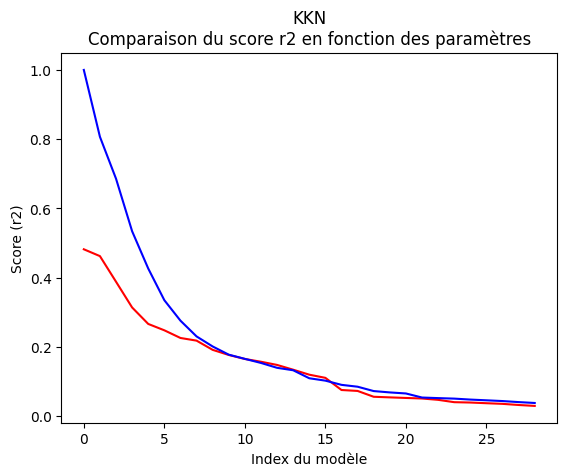

In [16]:
plt.plot(result["mean_test_score"], color="red")
plt.plot(result["mean_train_score"], color="blue")
plt.title("KKN\nComparaison du score r2 en fonction des paramètres")
plt.ylabel("Score (r2)")
plt.xlabel("Index du modèle")
plt.savefig("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_kkn_score.png", dpi=300)

# RandomForestRegressor

In [17]:
tt = TransformedTargetRegressor(regressor=RandomForestRegressor(),func=np.log1p, inverse_func=np.expm1)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

param_grid = {
    'model__regressor__n_estimators': [100],          # Number of trees in the forest
    'model__regressor__max_depth': [None, 10, 20, 30],        # Maximum depth of each tree
    'model__regressor__min_samples_split': [2, 5, 10],       # Minimum number of samples to split a node
    'model__regressor__min_samples_leaf': [1, 2, 4],         # Bootstrap Aggregating (Bagging)
}

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1, verbose=1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
0.2286756563401736
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['index', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'Prop.Electricity', 'Prop.NaturalGas',
       'Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse', 'Dat...
       'Worship Facility', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Enclosed Mall', 'Food Sales',
       'Swimming Pool', 'Vocational School', 'Fast Food Restaurant',
       'Other - Technology/Science'],
      dtype='object'))])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 

In [18]:
result = pd.DataFrame(grid_search.cv_results_)
display(result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__max_depth,param_model__regressor__min_samples_leaf,param_model__regressor__min_samples_split,param_model__regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.390609,0.401426,0.065031,0.023947,None,1,2,100,"{'model__regressor__max_depth': None, 'model__...",0.148122,0.303803,0.174078,0.208668,0.068100,18,0.678195,0.688187,0.670166,0.678849,0.007372
1,3.227893,0.361508,0.069095,0.008256,None,1,5,100,"{'model__regressor__max_depth': None, 'model__...",0.149018,0.322752,0.156970,0.209580,0.080091,16,0.561888,0.646389,0.631079,0.613119,0.036761
2,3.333073,0.027506,0.082104,0.025856,None,1,10,100,"{'model__regressor__max_depth': None, 'model__...",0.155553,0.319529,0.175307,0.216796,0.073089,7,0.445465,0.578929,0.549891,0.524762,0.057311
3,2.710636,0.598996,0.046208,0.025831,None,2,2,100,"{'model__regressor__max_depth': None, 'model__...",0.141200,0.323644,0.189370,0.218071,0.077198,5,0.472052,0.495483,0.529839,0.499125,0.023731
4,3.284497,0.114548,0.092491,0.004229,None,2,5,100,"{'model__regressor__max_depth': None, 'model__...",0.151979,0.312215,0.176749,0.213648,0.070427,11,0.478372,0.503928,0.455932,0.479411,0.019608
5,2.512289,0.758793,0.049682,0.015145,None,2,10,100,"{'model__regressor__max_depth': None, 'model__...",0.141090,0.272254,0.167442,0.193596,0.056651,34,0.380810,0.405981,0.449668,0.412153,0.028448
6,2.234813,0.628639,0.040874,0.023390,None,4,2,100,"{'model__regressor__max_depth': None, 'model__...",0.153980,0.358412,0.137501,0.216631,0.100480,8,0.371218,0.341842,0.367140,0.360067,0.012994
7,2.192635,0.295547,0.032806,0.023234,None,4,5,100,"{'model__regressor__max_depth': None, 'model__...",0.145767,0.341178,0.157992,0.214979,0.089376,10,0.364129,0.343678,0.349708,0.352505,0.008580
8,2.021071,0.453778,0.036821,0.020646,None,4,10,100,"{'model__regressor__max_depth': None, 'model__...",0.149972,0.319841,0.169375,0.213063,0.075918,12,0.339178,0.338167,0.336654,0.338000,0.001037
9,2.195619,0.560778,0.044703,0.024476,10,1,2,100,"{'model__regressor__max_depth': 10, 'model__re...",0.153415,0.291006,0.176694,0.207038,0.060130,23,0.639488,0.647830,0.646603,0.644640,0.003678


In [19]:
result.to_csv("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_RandomForest_result.csv", sep=";")

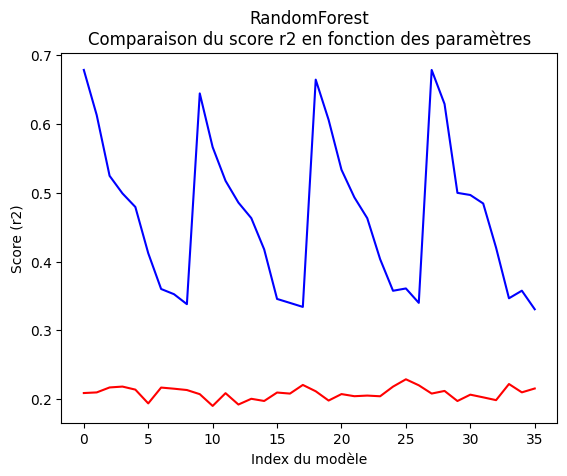

In [20]:
plt.plot(result["mean_test_score"], color="red")
plt.plot(result["mean_train_score"], color="blue")
plt.title("RandomForest\nComparaison du score r2 en fonction des paramètres")
plt.ylabel("Score (r2)")
plt.xlabel("Index du modèle")
plt.savefig("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_RandomForest_score.png", dpi=300)

# GradientBoostingRegressor()

In [21]:
tt = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),func=np.log1p, inverse_func=np.expm1)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

param_grid = {
    'model__regressor__n_estimators': [10, 100, 200],          # Number of trees in the forest
    'model__regressor__min_samples_split': [2, 5, 10],       # Minimum number of samples to split a node
    'model__regressor__min_samples_leaf': [1, 2, 4],
    #'model__learning_rate': [0.1, 0.01, 0.001],       # Bootstrap Aggregating (Bagging)
}

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1, verbose=1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


0.4324003093338347
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['index', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'Prop.Electricity', 'Prop.NaturalGas',
       'Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse', 'Dat...
       'Worship Facility', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Enclosed Mall', 'Food Sales',
       'Swimming Pool', 'Vocational School', 'Fast Food Restaurant',
       'Other - Technology/Science'],
      dtype='object'))])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_

In [22]:
result = pd.DataFrame(grid_search.cv_results_)
display(result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__min_samples_leaf,param_model__regressor__min_samples_split,param_model__regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.116444,0.032749,0.008000,0.001633,1,2,10,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.004935,0.079867,0.040586,0.041796,0.030603,22,0.067932,0.095466,0.072507,0.078635,0.012047
1,1.318860,0.418128,0.012530,0.005399,1,2,100,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.383033,0.405296,0.224550,0.337626,0.080472,7,0.625224,0.734344,0.783890,0.714486,0.066279
2,2.436516,0.720271,0.031485,0.022864,1,2,200,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.564879,0.439691,0.222719,0.409096,0.141352,2,0.843627,0.889040,0.896805,0.876491,0.023453
3,0.220285,0.017155,0.007950,0.001642,1,5,10,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.000298,0.089223,0.040586,0.043369,0.036357,19,0.067950,0.076940,0.072507,0.072465,0.003670
4,1.183152,0.352911,0.004728,0.003460,1,5,100,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.520934,0.393130,0.222069,0.378711,0.122436,5,0.582490,0.706826,0.759381,0.682899,0.074171
5,1.559400,0.160331,0.013028,0.011901,1,5,200,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.717392,0.001492,0.271740,0.330208,0.295175,8,0.798358,0.834644,0.880800,0.837934,0.033737
6,0.224321,0.023015,0.005137,0.003659,1,10,10,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.000014,0.089223,0.040586,0.043274,0.036469,20,0.067792,0.076940,0.072507,0.072413,0.003735
7,1.008979,0.299147,0.006151,0.002658,1,10,100,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.495684,0.466788,0.208986,0.390486,0.128881,3,0.560925,0.691187,0.777288,0.676467,0.088941
8,2.736413,0.097005,0.047273,0.031030,1,10,200,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.664544,0.537474,0.095183,0.432400,0.244027,1,0.768486,0.823003,0.869525,0.820338,0.041292
9,0.235972,0.019810,0.008172,0.006972,2,2,10,"{'model__regressor__min_samples_leaf': 2, 'mod...",-0.001279,0.096799,0.037998,0.044506,0.040304,17,0.066463,0.075918,0.069432,0.070604,0.003948


In [23]:
result.to_csv("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_GradienBoosting_result.csv", sep=";")

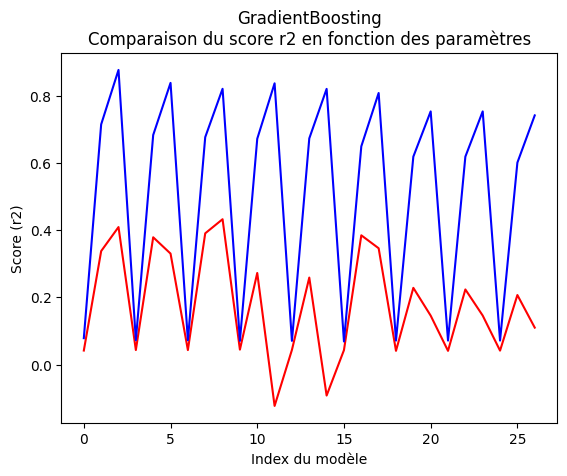

In [24]:
plt.plot(result["mean_test_score"], color="red")
plt.plot(result["mean_train_score"], color="blue")
plt.title("GradientBoosting\nComparaison du score r2 en fonction des paramètres")
plt.ylabel("Score (r2)")
plt.xlabel("Index du modèle")
plt.savefig("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_GradientBoosting_score.png", dpi=300)

# SVR

In [25]:
"""'model__regressor__C': [-1000, -100, -10, -1, -0.1, 0.1, 1, 10, 100, 1000],
    'model__regressor__gamma': [-0.0001, -0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 0.0001],"""

"'model__regressor__C': [-1000, -100, -10, -1, -0.1, 0.1, 1, 10, 100, 1000],\n    'model__regressor__gamma': [-0.0001, -0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 0.0001],"

In [26]:
"""tt = TransformedTargetRegressor(regressor=SVR(),func=np.log1p, inverse_func=np.expm1)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

param_grid = {
    'model__regressor__C': [0.1, 1, 10, 100, 1000],
    'model__regressor__gamma': [0.1, 0.01, 0.001, 0.0001],
    } 

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1, verbose=1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)"""

"tt = TransformedTargetRegressor(regressor=SVR(),func=np.log1p, inverse_func=np.expm1)\n\n# Create the final pipeline\npipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                           ('model', tt)])\n\nparam_grid = {\n    'model__regressor__C': [0.1, 1, 10, 100, 1000],\n    'model__regressor__gamma': [0.1, 0.01, 0.001, 0.0001],\n    } \n\n# Perform a grid search to find the best model and parameters\ngrid_search = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1, verbose=1, scoring='r2', return_train_score=True)\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters and the best score\nbest_params = grid_search.best_params_\n\n# Get the results\nprint(grid_search.best_score_)\nprint(grid_search.best_estimator_)\nprint(grid_search.best_params_)"

In [27]:
result = pd.DataFrame(grid_search.cv_results_)
display(result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__min_samples_leaf,param_model__regressor__min_samples_split,param_model__regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.116444,0.032749,0.008000,0.001633,1,2,10,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.004935,0.079867,0.040586,0.041796,0.030603,22,0.067932,0.095466,0.072507,0.078635,0.012047
1,1.318860,0.418128,0.012530,0.005399,1,2,100,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.383033,0.405296,0.224550,0.337626,0.080472,7,0.625224,0.734344,0.783890,0.714486,0.066279
2,2.436516,0.720271,0.031485,0.022864,1,2,200,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.564879,0.439691,0.222719,0.409096,0.141352,2,0.843627,0.889040,0.896805,0.876491,0.023453
3,0.220285,0.017155,0.007950,0.001642,1,5,10,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.000298,0.089223,0.040586,0.043369,0.036357,19,0.067950,0.076940,0.072507,0.072465,0.003670
4,1.183152,0.352911,0.004728,0.003460,1,5,100,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.520934,0.393130,0.222069,0.378711,0.122436,5,0.582490,0.706826,0.759381,0.682899,0.074171
5,1.559400,0.160331,0.013028,0.011901,1,5,200,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.717392,0.001492,0.271740,0.330208,0.295175,8,0.798358,0.834644,0.880800,0.837934,0.033737
6,0.224321,0.023015,0.005137,0.003659,1,10,10,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.000014,0.089223,0.040586,0.043274,0.036469,20,0.067792,0.076940,0.072507,0.072413,0.003735
7,1.008979,0.299147,0.006151,0.002658,1,10,100,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.495684,0.466788,0.208986,0.390486,0.128881,3,0.560925,0.691187,0.777288,0.676467,0.088941
8,2.736413,0.097005,0.047273,0.031030,1,10,200,"{'model__regressor__min_samples_leaf': 1, 'mod...",0.664544,0.537474,0.095183,0.432400,0.244027,1,0.768486,0.823003,0.869525,0.820338,0.041292
9,0.235972,0.019810,0.008172,0.006972,2,2,10,"{'model__regressor__min_samples_leaf': 2, 'mod...",-0.001279,0.096799,0.037998,0.044506,0.040304,17,0.066463,0.075918,0.069432,0.070604,0.003948


In [28]:
result.to_csv("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_SVR_result.csv", sep=";")

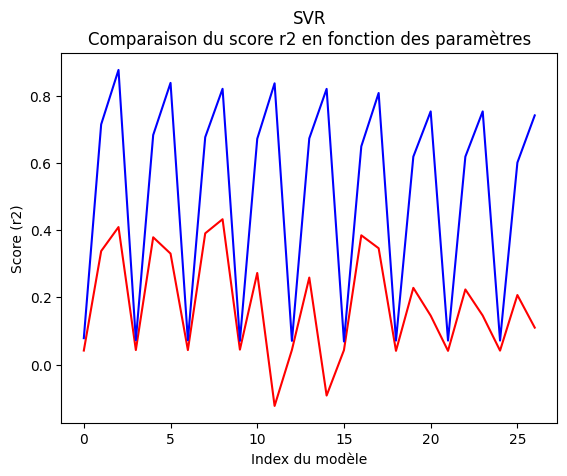

In [29]:
plt.plot(result["mean_test_score"], color="red")
plt.plot(result["mean_train_score"], color="blue")
plt.title("SVR\nComparaison du score r2 en fonction des paramètres")
plt.ylabel("Score (r2)")
plt.xlabel("Index du modèle")
plt.savefig("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_SVR_score.png", dpi=300)

# Ridge

In [30]:
tt = TransformedTargetRegressor(regressor=Ridge(),func=np.log1p, inverse_func=np.exp)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

param_grid = {
    'model__regressor__alpha': [1, 1e1, 1e3, 1e5, 1e8],
}

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1, verbose=1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


-0.07512002499686636
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['index', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'Prop.Electricity', 'Prop.NaturalGas',
       'Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse', 'Dat...
       'Urgent Care/Clinic/Other Outpatient', 'Wholesale Club/Supercenter',
       'Worship Facility', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Enclosed Mall', 'Food Sales',
       'Swimming Pool', 'Vocational School', 'Fast Food Restaurant',
       'Other - Technology/Science'],
      dtype='object'))])),
                ('model',
                 TransformedTargetRegres

c:\Users\remid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


In [31]:
result = pd.DataFrame(grid_search.cv_results_)
display(result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.090191,0.020447,0.023409,0.018581,1,{'model__regressor__alpha': 1},-2548.194163,-7.794025e+22,-2374.611994,-2.598008e+22,3.674139e+22,5,-6.545283,-6.638650,-2.831614,-5.338516,1.773057
1,0.089953,0.003936,0.008838,0.001934,10.0,{'model__regressor__alpha': 10.0},-2318.119439,-2.570282e+22,-2240.918587,-8.567606e+21,1.211642e+22,4,-4.836886,-5.943448,-2.423741,-4.401358,1.469546
2,0.020949,0.002038,0.006089,0.000710,1000.0,{'model__regressor__alpha': 1000.0},0.555921,-2.588038e+06,0.590537,-8.626789e+05,1.220013e+06,3,0.304555,0.345945,0.398465,0.349655,0.038428
3,0.017608,0.000723,0.008731,0.002674,100000.0,{'model__regressor__alpha': 100000.0},-0.080711,-8.805881e-02,-0.056590,-7.512002e-02,1.344172e-02,1,-0.072509,-0.064869,-0.068243,-0.068540,0.003126
4,0.017197,0.000436,0.005567,0.000800,100000000.0,{'model__regressor__alpha': 100000000.0},-0.083761,-9.529592e-02,-0.059539,-7.953218e-02,1.490076e-02,2,-0.076230,-0.068003,-0.072133,-0.072122,0.003359


In [32]:
result.to_csv("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_Ridge_result.csv", sep=";")

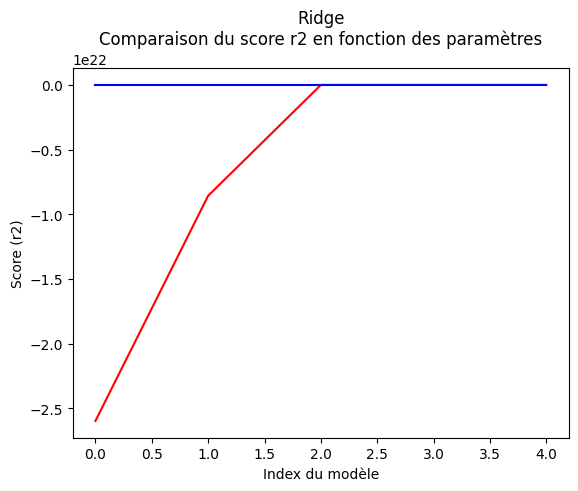

In [33]:
plt.plot(result["mean_test_score"], color="red")
plt.plot(result["mean_train_score"], color="blue")
plt.title("Ridge\nComparaison du score r2 en fonction des paramètres")
plt.ylabel("Score (r2)")
plt.xlabel("Index du modèle")
plt.savefig("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_Ridge_score.png", dpi=300)

# Lasso

In [34]:
tt = TransformedTargetRegressor(regressor=Lasso(),func=np.log1p, inverse_func=np.exp)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

param_grid = {
    'model__regressor__alpha': [1e-4, 1e-1, 1, 1e1, 1e3, 1e4, 1e5, 1e6],
}

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, n_jobs=-1, verbose=1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.11646806387856574
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['index', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'Prop.Electricity', 'Prop.NaturalGas',
       'Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse', 'Dat...
       'Urgent Care/Clinic/Other Outpatient', 'Wholesale Club/Supercenter',
       'Worship Facility', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Enclosed Mall', 'Food Sales',
       'Swimming Pool', 'Vocational School', 'Fast Food Restaurant',
       'Other - Technology/Science'],
      dtype='object'))])),
       

c:\Users\remid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:190: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


In [35]:
result = pd.DataFrame(grid_search.cv_results_)
display(result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regressor__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.052819,0.045955,0.008771,0.003565,0.0001,{'model__regressor__alpha': 0.0001},-2552.109771,-7.698969e+22,-2367.267913,-2.566323e+22,3.629329e+22,8,-6.713258,-6.683961,-2.867748,-5.421656,1.805925
1,0.020140,0.003894,0.006473,0.001055,0.1,{'model__regressor__alpha': 0.1},0.315847,-1.341408e-01,0.167698,1.164681e-01,1.872444e-01,1,0.286193,0.371209,0.409236,0.355546,0.051439
2,0.017382,0.000767,0.007375,0.000332,1,{'model__regressor__alpha': 1},-0.083764,-9.530303e-02,-0.059542,-7.953652e-02,1.490225e-02,2,-0.076233,-0.068006,-0.072137,-0.072125,0.003359
3,0.015154,0.000461,0.010271,0.005013,10.0,{'model__regressor__alpha': 10.0},-0.083764,-9.530303e-02,-0.059542,-7.953652e-02,1.490225e-02,2,-0.076233,-0.068006,-0.072137,-0.072125,0.003359
4,0.049881,0.044512,0.003840,0.002722,1000.0,{'model__regressor__alpha': 1000.0},-0.083764,-9.530303e-02,-0.059542,-7.953652e-02,1.490225e-02,2,-0.076233,-0.068006,-0.072137,-0.072125,0.003359
5,0.018334,0.001247,0.007819,0.001559,10000.0,{'model__regressor__alpha': 10000.0},-0.083764,-9.530303e-02,-0.059542,-7.953652e-02,1.490225e-02,2,-0.076233,-0.068006,-0.072137,-0.072125,0.003359
6,0.020816,0.002072,0.004821,0.002978,100000.0,{'model__regressor__alpha': 100000.0},-0.083764,-9.530303e-02,-0.059542,-7.953652e-02,1.490225e-02,2,-0.076233,-0.068006,-0.072137,-0.072125,0.003359
7,0.016857,0.003450,0.008588,0.003601,1000000.0,{'model__regressor__alpha': 1000000.0},-0.083764,-9.530303e-02,-0.059542,-7.953652e-02,1.490225e-02,2,-0.076233,-0.068006,-0.072137,-0.072125,0.003359


In [36]:
result.to_csv("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_Lasso_result.csv", sep=";")

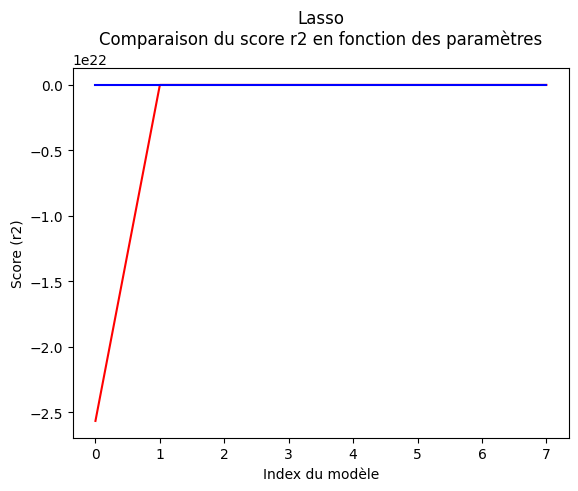

In [37]:
plt.plot(result["mean_test_score"], color="red")
plt.plot(result["mean_train_score"], color="blue")
plt.title("Lasso\nComparaison du score r2 en fonction des paramètres")
plt.ylabel("Score (r2)")
plt.xlabel("Index du modèle")
plt.savefig("C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/v1_Lasso_score.png", dpi=300)

hyperopt, optuna -> 

Faire Grid search CV sur la pipeline (ajouter return_train_score = True)

In [42]:
df

,index,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,SiteEnergyUseWN(kBtu),Prop.Electricity,Prop.NaturalGas,Adult Education,Automobile Dealership,Bank Branch,College/University,Convention Center,Courthouse,Data Center,Distribution Center,Financial Office,Fire Station,Fitness Center/Health Club/Gym,Food Service,Hospital (General Medical & Surgical),Hotel,K-12 School,Laboratory,Library,Lifestyle Center,Manufacturing/Industrial Plant,Medical Office,Movie Theater,Multifamily Housing,Museum,Non-Refrigerated Warehouse,Office,Other,Other - Education,Other - Entertainment/Public Assembly,Other - Lodging/Residential,Other - Mall,Other - Public Services,Other - Recreation,Other - Restaurant/Bar,Other - Services,Other - Utility,Other/Specialty Hospital,Parking,Performing Arts,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Police Station,Pre-school/Daycare,Prison/Incarceration,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Residence Hall/Dormitory,Residential Care Facility,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Wholesale Club/Supercenter,Worship Facility,Bar/Nightclub,Convenience Store without Gas Station,Enclosed Mall,Food Sales,Swimming Pool,Vocational School,Fast Food Restaurant,Other - Technology/Science
0,0,7,1927,1,12,7456910,54.61,17.66,0,0,0,0,0,0,0,0,0,0,0,0,0,88434,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7,1996,1,11,8664479,38.66,61.34,0,0,0,0,0,0,0,0,0,0,0,0,0,83880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15064,0,0,0,0,0,0,0,0,0,4622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,7,1969,1,41,73937112,68.23,2.06,0,0,0,0,0,0,0,0,0,0,0,0,0,756493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,7,1926,1,10,6946800,40.75,26.66,0,0,0,0,0,0,0,0,0,0,0,0,0,61320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,7,1980,1,18,14656503,37.88,62.12,0,0,0,0,0,0,0,0,0,0,0,0,0,123445,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,3371,2,1990,1,1,943003,61.70,38.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1519,3372,2,2004,1,1,1053705,41.73,58.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1520,3373,7,1974,1,1,6053764,31.08,68.92,0,0,0,0,0,0,0,0,0,0,5574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1521,3374,1,1989,1,1,782841,48.49,51.51,0,0,0,0,0,0,0,0,0,0,6501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6601,0,0,0,0,0,0,0,0,484,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
df_final = pd.merge(df, df1[["Unnamed: 0","ENERGYSTARScore"]], left_on="index", right_on="Unnamed: 0", how="left")

,index,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,SiteEnergyUseWN(kBtu),Prop.Electricity,Prop.NaturalGas,Adult Education,Automobile Dealership,Bank Branch,College/University,Convention Center,Courthouse,Data Center,Distribution Center,Financial Office,Fire Station,Fitness Center/Health Club/Gym,Food Service,Hospital (General Medical & Surgical),Hotel,K-12 School,Laboratory,Library,Lifestyle Center,Manufacturing/Industrial Plant,Medical Office,Movie Theater,Multifamily Housing,Museum,Non-Refrigerated Warehouse,Office,Other,Other - Education,Other - Entertainment/Public Assembly,Other - Lodging/Residential,Other - Mall,Other - Public Services,Other - Recreation,Other - Restaurant/Bar,Other - Services,Other - Utility,Other/Specialty Hospital,Parking,Performing Arts,"Personal Services (Health/Beauty, Dry Cleaning, etc)",Police Station,Pre-school/Daycare,Prison/Incarceration,Refrigerated Warehouse,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Residence Hall/Dormitory,Residential Care Facility,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Wholesale Club/Supercenter,Worship Facility,Bar/Nightclub,Convenience Store without Gas Station,Enclosed Mall,Food Sales,Swimming Pool,Vocational School,Fast Food Restaurant,Other - Technology/Science,Unnamed: 0,ENERGYSTARScore
0,0,7,1927,1,12,7456910,54.61,17.66,0,0,0,0,0,0,0,0,0,0,0,0,0,88434,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60.0
1,1,7,1996,1,11,8664479,38.66,61.34,0,0,0,0,0,0,0,0,0,0,0,0,0,83880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15064,0,0,0,0,0,0,0,0,0,4622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,61.0
2,2,7,1969,1,41,73937112,68.23,2.06,0,0,0,0,0,0,0,0,0,0,0,0,0,756493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,43.0
3,3,7,1926,1,10,6946800,40.75,26.66,0,0,0,0,0,0,0,0,0,0,0,0,0,61320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,56.0
4,4,7,1980,1,18,14656503,37.88,62.12,0,0,0,0,0,0,0,0,0,0,0,0,0,123445,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,3371,2,1990,1,1,943003,61.70,38.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3371,46.0
1517,3372,2,2004,1,1,1053705,41.73,58.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3372,NaN
1518,3373,7,1974,1,1,6053764,31.08,68.92,0,0,0,0,0,0,0,0,0,0,5574,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3373,NaN
1519,3374,1,1989,1,1,782841,48.49,51.51,0,0,0,0,0,0,0,0,0,0,6501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6601,0,0,0,0,0,0,0,0,484,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3374,NaN


In [50]:
df_final = df_final.drop(columns="Unnamed: 0")

In [55]:
df_final.isna().mean().sort_values(ascending=False).head(5)

ENERGYSTARScore                                    0.34714
Other - Mall                                       0.00000
Residential Care Facility                          0.00000
Residence Hall/Dormitory                           0.00000
Repair Services (Vehicle, Shoe, Locksmith, etc)    0.00000
dtype: float64

In [57]:
df_final = df_final.dropna(subset="ENERGYSTARScore")

In [59]:
X = df_final.drop(columns="SiteEnergyUseWN(kBtu)")
y = df_final["SiteEnergyUseWN(kBtu)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

#categorical_transformer = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.columns)])
#        ('cat', categorical_transformer, categorical_cols)])


In [60]:
tt = TransformedTargetRegressor(regressor=KNeighborsRegressor(),func=np.log1p, inverse_func=np.expm1)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'model__regressor__n_neighbors': list(range(1, 30)),
}

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, verbose=1, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
0.6286571342352885
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['index', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'Prop.Electricity', 'Prop.NaturalGas',
       'Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse', 'Dat...
       'Worship Facility', 'Bar/Nightclub',
       'Convenience Store without Gas Station', 'Enclosed Mall', 'Food Sales',
       'Swimming Pool', 'Vocational School', 'Fast Food Restaurant',
       'Other - Technology/Science', 'ENERGYSTARScore'],
      dtype='object'))])),
                ('model',
                 TransformedTargetRegr

In [ ]:
import shap

In [39]:

Etudier l'importance des variables uniquement sur le meilleur model

feature_importance (local)

mettre dans la pipeline, à la place du standardScaler un powertransformer(choisi la meilleur transformation possible)

Garder les résultats des modèles (exporter csv avec résultat)



SyntaxError: unterminated string literal (detected at line 1) (1196697725.py, line 1)